In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import kruskal
from scipy.stats import gaussian_kde

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))

import galileo as gal
import huygens as huy

from collections import Counter

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests


# Transcripts to genes

In [5]:
t2g = pd.read_csv("../data/intermediate/sleuth_diff/ensembl_t2g.csv")
t2g["format_gene_id"] = t2g["hgnc_gene"].fillna("") + "_" + t2g["ens_gene"]

format_gene_map = dict(zip(t2g["ens_gene"],t2g["format_gene_id"]))

# Preprocess TCGA

In [6]:
tcga_genex = pd.read_hdf("../../data/processed/TCGA/TCGA_genex_norm.h5",key="tcga_genex")
tcga_cn = pd.read_hdf("../data/processed/tcga/tcga_cn.hdf",key="tcga_cn")
tcga_muts = pd.read_hdf("../data/processed/tcga/tcga_muts.hdf",key="tcga_muts")
tcga_sample_info = pd.read_hdf("../data/processed/tcga/tcga_sample_info.hdf",
                               key="tcga_sample_info")

tcga_map = {
    'acute myeloid leukemia': "LAML",
    'adrenocortical cancer': "ACC",
    'bladder urothelial carcinoma': "BLCA",
    'brain lower grade glioma': "LGG",
    'breast invasive carcinoma': "BRCA",
    'cervical & endocervical cancer': "CESC",
    'cholangiocarcinoma': "CHOL",
    'colon adenocarcinoma': "COAD",
    'diffuse large B-cell lymphoma': "DLBC",
    'esophageal carcinoma': "ESCA",
    'glioblastoma multiforme': "GBM",
    'head & neck squamous cell carcinoma': "HNSC",
    'kidney chromophobe': "KICH",
    'kidney clear cell carcinoma': "KIRC",
    'kidney papillary cell carcinoma': "KIRP",
    'liver hepatocellular carcinoma': "LIHC",
    'lung adenocarcinoma': "LUAD",
    'lung squamous cell carcinoma': "LUSC",
    'mesothelioma': "MESO",
    'ovarian serous cystadenocarcinoma': "OV",
    'pancreatic adenocarcinoma': "PAAD",
    'pheochromocytoma & paraganglioma': "PCPG",
    'prostate adenocarcinoma': "PRAD",
    'rectum adenocarcinoma': "READ",
    'sarcoma': "SARC",
    'skin cutaneous melanoma': "SKCM",
    'stomach adenocarcinoma': "STAD",
    'testicular germ cell tumor': "TGCT",
    'thymoma': "THYM",
    'thyroid carcinoma': "THCA",
    'uterine carcinosarcoma': "UCS",
    'uterine corpus endometrioid carcinoma': "UCEC",
    'uveal melanoma': "UVM"
}

tcga_sample_info["abbreviated_disease"] = tcga_sample_info["_primary_disease"].apply(
    lambda x: tcga_map[x])

In [6]:
tcga_splicing = pd.read_hdf("../../data/processed/TCGA/merged.h5",key="tcga_splicing")


tcga_splicing.index = tcga_splicing.index.map(lambda x: x[:15])

tcga_splicing = tcga_splicing[~tcga_splicing.index.duplicated(keep="first")]

tcga_splicing.columns = [format_gene_map.get(x.split(".")[0],"unnamed")+"_"+x for x in tcga_splicing.columns]

normal_genex = tcga_genex[tcga_genex.index.map(lambda x: x[-2:] == "11")]
normal_splicing = tcga_splicing[tcga_splicing.index.map(lambda x: x[-2:] == "11")]

tcga_genex = tcga_genex[tcga_genex.index.map(lambda x: x[-2:] != "11")]
tcga_splicing = tcga_splicing[tcga_splicing.index.map(lambda x: x[-2:] != "11")]

## RPL22 mutants

In [8]:
rpl22_mut = pd.Series(index=sorted(set(tcga_muts.index)))

damaging_effects = ["Frame_Shift_Del",
                    "Frame_Shift_Ins",
                    "Nonsense_Mutation",
                    "Nonstop_Mutation",
                    "Splice_Site",
                    "Translation_Start_Site",
                    "large deletion"
                    ]

truncated = tcga_muts[(tcga_muts["gene"] == "RPL22")]
truncated = truncated[truncated["effect"].isin(damaging_effects)].index
truncated = set(truncated)

rpl22_mut = pd.Series(rpl22_mut.index.map(
    lambda x: x in truncated), index=rpl22_mut.index)
rpl22_mut.name = "RPL22_trunc"

In [9]:
rpl22_info = pd.concat([rpl22_mut,
                        tcga_cn["RPL22"].rename("RPL22_cn")],
                       axis=1,
                       sort=True,
                       join="inner"
                       )

# Boxplots

In [10]:
def rpl22_status(row):
    if row["RPL22_trunc"]:
        return "Truncating\nmutation"

    else:
        return "ΔCN=" + str(int(row["RPL22_cn"]))


rpl22_info["RPL22_status"] = rpl22_info.apply(rpl22_status, axis=1)

rpl22_order = ["Truncating\nmutation",
               "ΔCN=-2",
               "ΔCN=-1",
               "ΔCN=0",
               "ΔCN=1",
               "ΔCN=2"
               ]

mut_hue = "#e23e57"
wt_hue = "#eaeaea"

rpl22_hues = dict(zip(rpl22_order, [mut_hue]+[wt_hue]*5))

In [11]:
def plot_rpl22(y, ylabel="y"):

    plt.figure(figsize=(5, 3))

    ax = plt.subplot(111)

    rpl22_info_join = rpl22_info.join(y.dropna(), how="inner")

    rpl22_counts = rpl22_info_join["RPL22_status"].value_counts()

    grouped_y = rpl22_info_join.groupby("RPL22_status")[y.name].apply(list)
    grouped_y = list(grouped_y)

    pval = kruskal(*grouped_y)[1]

    flierprops = dict(marker='.', markersize=8,
                      markerfacecolor=(0, 0, 0, 0),
                      markeredgecolor="black",
                      markeredgewidth=0.5)

    sns.boxplot(
        rpl22_info["RPL22_status"],
        y,
        notch=True,
        order=rpl22_order,
        bootstrap=1000,
        palette=rpl22_hues,
        flierprops=flierprops
    )

    plt.xlabel("RPL22 status")
    plt.ylabel(ylabel)

    if pval == 0:
        plt.text(0.05, 1.025,
                 "P < " + huy.as_si(10**(-320), 2),
                 transform=ax.transAxes
                 )

    else:
        plt.text(0.05, 1.025,
                 "P = " + huy.as_si(pval, 2),
                 transform=ax.transAxes
                 )

    xticks = [x + "\n ("+str(int(rpl22_counts.loc[x])) +
              ")" for x in rpl22_order]

    ax.set_xticklabels(xticks)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.spines['left'].set_position(('axes', -0.025))
    ax.spines['bottom'].set_position(('axes', -0.025))

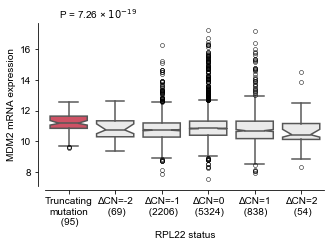

In [48]:
plot_rpl22(tcga_genex["MDM2_10743"],
           "MDM2 mRNA expression"
           )

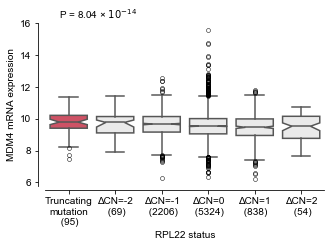

In [49]:
plot_rpl22(tcga_genex["MDM4_10744"],
           "MDM4 mRNA expression"
           )

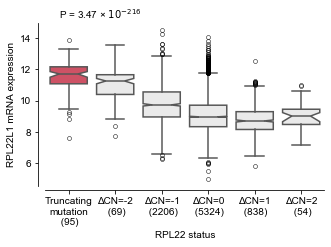

In [50]:
plot_rpl22(tcga_genex["RPL22L1_15209"],
           "RPL22L1 mRNA expression"
           )

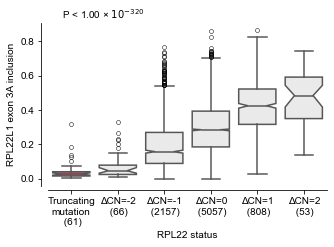

In [12]:
plot_rpl22(1-tcga_splicing["RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"],
           "RPL22L1 exon 3A inclusion"
           )

plt.savefig("../plots/rpl22l1-exon-3a_rpl22_tcga.pdf",
            bbox_inches="tight", transparent=True)

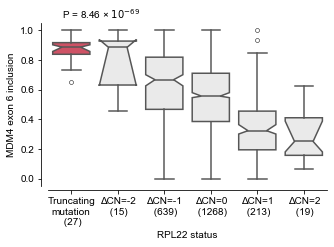

In [13]:
plot_rpl22(tcga_splicing["MDM4_ENSG00000198625_ENSG00000198625.8_ES_1_204501318:204501374:204506557:204506625:204507336:204507436_204506557:204506625"],
           "MDM4 exon 6 inclusion",
           )

plt.savefig("../plots/mdm4-exon-6_rpl22_tcga.pdf",
            bbox_inches="tight", transparent=True)

# Scatterplots

In [14]:
def density_scatter(x, y):

    x = x.dropna()
    y = y.dropna()

    x, y = x.align(y, join="inner")

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    plt.figure(figsize=(3, 3))
    ax = plt.subplot(111)

    ax.scatter(x, y,
               c=z,
               s=8,
               cmap="Blues",
               rasterized=True,
               vmin=min(z)-1
               )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax

## RPL22L1 3A vs expression

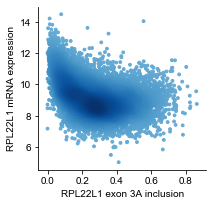

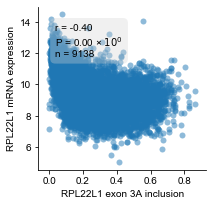

In [15]:
x = 1-tcga_splicing["RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"]
y = tcga_genex["RPL22L1_15209"]

ax = density_scatter(x, y)

ax.set_xlabel("RPL22L1 exon 3A inclusion")
ax.set_ylabel("RPL22L1 mRNA expression")

plt.savefig("../plots/rpl22l1_splicing_expression_density.pdf",
            dpi=2048, bbox_inches="tight", background="transparent")

plt.figure(figsize=(3, 3))

huy.regression(x, y)

plt.xlabel("RPL22L1 exon 3A inclusion")
plt.ylabel("RPL22L1 mRNA expression")

plt.savefig("../plots/rpl22l1_splicing_expression_annotated.pdf",
            dpi=2048, bbox_inches="tight", background="transparent")

## RPL22L1 3A vs MDM4 6

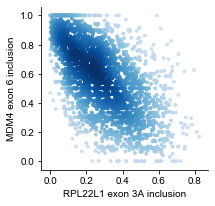

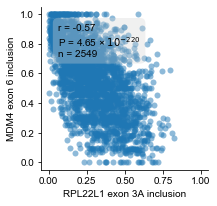

In [17]:
x = 1-tcga_splicing["RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"]
y = tcga_splicing["MDM4_ENSG00000198625_ENSG00000198625.8_ES_1_204501318:204501374:204506557:204506625:204507336:204507436_204506557:204506625"]

ax = density_scatter(x, y)

ax.set_xlabel("RPL22L1 exon 3A inclusion")
ax.set_ylabel("MDM4 exon 6 inclusion")

plt.savefig("../plots/rpl22l1_mdm4_co-splicing_density.pdf",
            dpi=2048, bbox_inches="tight", background="transparent")

plt.figure(figsize=(3, 3))

huy.regression(x, y)

plt.xlabel("RPL22L1 exon 3A inclusion")
plt.ylabel("MDM4 exon 6 inclusion")

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)

plt.savefig("../plots/rpl22l1_mdm4_co-splicing_annotated.pdf",
            dpi=2048, bbox_inches="tight", transparent=True)

# TCGA correlations

In [31]:
rpl22_cn_splicing = pd.read_hdf(
    "../data/intermediate/rpl22_cn_splicing.h5", key="rpl22_cn_splicing")

rpl22l1_genex_splicing = pd.read_hdf(
    "../data/intermediate/rpl22l1_genex_splicing.h5", key="rpl22l1_genex_splicing")
rpl22l1_genex_splicing_subtyped = pd.read_hdf("../data/intermediate/rpl22l1_genex_splicing_subtyped.h5",
                                              key="rpl22l1_genex_splicing_subtyped")

mdm4_splicing_genex = pd.read_hdf(
    "../data/intermediate/mdm4_splicing_genex.h5", key="mdm4_splicing_genex")

rpl22l1_splicing_genex = pd.read_hdf(
    "../data/intermediate/rpl22l1_splicing_genex.h5", key="rpl22l1_splicing_genex")

mdm4_splicing_genex_subtyped = pd.read_hdf(
    "../data/intermediate/mdm4_splicing_genex_subtyped.h5", key="mdm4_splicing_genex_subtyped")

rpl22l1_splicing_genex_subtyped = pd.read_hdf(
    "../data/intermediate/rpl22l1_splicing_genex_subtyped.h5", key="rpl22l1_splicing_genex_subtyped")

mdm4_cosplicing = pd.read_hdf(
    "../data/intermediate/mdm4_cosplicing.h5", key="mdm4_cosplicing")

rpl22l1_cosplicing = pd.read_hdf(
    "../data/intermediate/rpl22l1_cosplicing.h5", key="rpl22l1_cosplicing")

mdm4_cosplicing_subtyped = pd.read_hdf(
    "../data/intermediate/mdm4_cosplicing_subtyped.h5", key="mdm4_cosplicing_subtyped")
rpl22l1_cosplicing_subtyped = pd.read_hdf(
    "../data/intermediate/rpl22l1_cosplicing_subtyped.h5", key="rpl22l1_cosplicing_subtyped")

rpl22l1_genex_splicing_subtyped = rpl22l1_genex_splicing_subtyped[rpl22l1_genex_splicing_subtyped["n"] >= 100]
mdm4_splicing_genex_subtyped = mdm4_splicing_genex_subtyped[mdm4_splicing_genex_subtyped["n"] >= 100]
rpl22l1_splicing_genex_subtyped = rpl22l1_splicing_genex_subtyped[rpl22l1_splicing_genex_subtyped["n"] >= 100]
mdm4_cosplicing_subtyped = mdm4_cosplicing_subtyped[mdm4_cosplicing_subtyped["n"] >= 100]
rpl22l1_cosplicing_subtyped = rpl22l1_cosplicing_subtyped[rpl22l1_cosplicing_subtyped["n"] >= 100]

## Overall correlations

In [98]:
def volcano(corrs):
    corrs = corrs.sort_values(by="pval")
    corrs["qval"] = multipletests(
        10**(-corrs["pval"]), alpha=0.01, method="fdr_bh")[1]

    labels = pd.Series(corrs.index.map(
        lambda x: x.split("_")[0]), index=corrs.index)

    pos_ranks = corrs[corrs["corr"]>0]["qval"].rank()
    neg_ranks = corrs[corrs["corr"]<0]["qval"].rank()
    ranks = pd.concat([pos_ranks,neg_ranks])

    corrs["qval_rank"] = ranks
    
    pos_ranks = (-corrs[corrs["corr"]>0]["corr"]).rank()
    neg_ranks = corrs[corrs["corr"]<0]["corr"].rank()
    ranks = pd.concat([pos_ranks,neg_ranks])
    
    corrs["corr_rank"] = ranks

    ranks = pd.concat([pos_ranks,neg_ranks])

    huy.dense_plot(corrs["corr"],
                   -np.log10(corrs["qval"]),
                   labels_mask=(corrs["corr_rank"] < 6)|(corrs["qval_rank"] < 6),
                   labels=labels,
                   adjust=False,
                   c="black"
                   )
    
    plt.xlabel("Spearman correlation")
    plt.ylabel("-log10(q-value)")    

In [ ]:
rpl22_cn_splicing
rpl22l1_genex_splicing
mdm4_splicing_genex
rpl22l1_splicing_genex
mdm4_cosplicing
rpl22l1_cosplicing

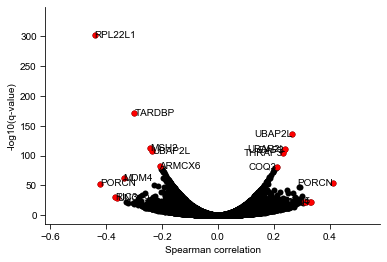

In [99]:
volcano(rpl22_cn_splicing)

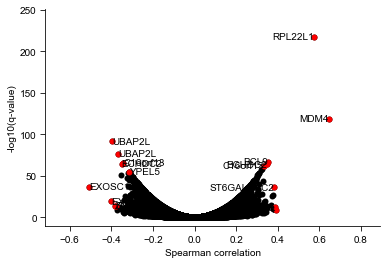

In [103]:
volcano(mdm4_cosplicing)

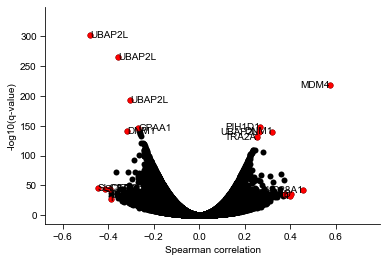

In [104]:
volcano(rpl22l1_cosplicing)

## Subtype correlations

In [41]:
rpl22l1_gene = "RPL22L1_15209"
rpl22l1_exon_3a = "RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"
mdm4_exon_6 = "MDM4_ENSG00000198625_ENSG00000198625.8_ES_1_204501318:204501374:204506557:204506625:204507336:204507436_204506557:204506625"

In [36]:
# reset indices
rpl22l1_genex_splicing_subtyped = rpl22l1_genex_splicing_subtyped.set_index(rpl22l1_gene)

mdm4_splicing_genex_subtyped = mdm4_splicing_genex_subtyped.set_index(mdm4_exon_6)
rpl22l1_splicing_genex_subtyped = rpl22l1_splicing_genex_subtyped.set_index(rpl22l1_exon_3a)

mdm4_cosplicing_subtyped = mdm4_cosplicing_subtyped.set_index(mdm4_exon_6)
rpl22l1_cosplicing_subtyped = rpl22l1_cosplicing_subtyped.set_index(rpl22l1_exon_3a)

# remove self correlations

mdm4_cosplicing = mdm4_cosplicing[mdm4_cosplicing.index.map(lambda x: x!=mdm4_exon_6)]
rpl22l1_cosplicing = rpl22l1_cosplicing[rpl22l1_cosplicing.index.map(lambda x: x!=rpl22l1_exon_3a)]

mdm4_cosplicing_subtyped = mdm4_cosplicing_subtyped[mdm4_cosplicing_subtyped[mdm4_exon_6]!=mdm4_exon_6]
rpl22l1_cosplicing_subtyped = rpl22l1_cosplicing_subtyped[rpl22l1_cosplicing_subtyped[rpl22l1_exon_3a]!=rpl22l1_exon_3a]

In [61]:
def plot_subtype_corrs(corrs,subplot_dim,figsize):

    subtype_diseases = sorted(list(set(corrs["abbreviated_disease"])))

    fig, axes = plt.subplots(subplot_dim[0], subplot_dim[1], figsize=figsize, sharex=True)

    axes = [x for y in axes for x in y]
    
    xmin = min(corrs["corr"])
    xmax = max(corrs["corr"])

    for subtype_idx, subtype in enumerate(subtype_diseases):

        ax = axes[subtype_idx]

        subtype_corrs = corrs[corrs["abbreviated_disease"] == subtype]
        subtype_corrs = subtype_corrs.sort_values(by="pval")
        subtype_corrs["qval"] = multipletests(
            10**(-subtype_corrs["pval"]), alpha=0.01, method="fdr_bh")[1]

        subtype_labels = pd.Series(subtype_corrs.index.map(
            lambda x: x.split("_")[0]), index=subtype_corrs.index)
        
        pos_ranks = subtype_corrs[subtype_corrs["corr"]>0]["qval"].rank()
        neg_ranks = subtype_corrs[subtype_corrs["corr"]<0]["qval"].rank()
        
        ranks = pd.concat([pos_ranks,neg_ranks])
        
        subtype_corrs["rank"] = ranks

        huy.dense_plot(subtype_corrs["corr"],
                       -np.log10(subtype_corrs["qval"]),
                       labels_mask=subtype_corrs["rank"] < 5,
                       labels=subtype_labels,
                       adjust=False,
                       ax=ax,
                       c="black"
                       )

        ax.set_title(subtype)

    plt.xlim(xmin-0.05, xmax+0.05)
    
    fig.text(0.5, 0.08, 'Spearman correlation', ha='center')
    fig.text(0.08, 0.5, '-log10(q-value)', va='center', rotation='vertical')

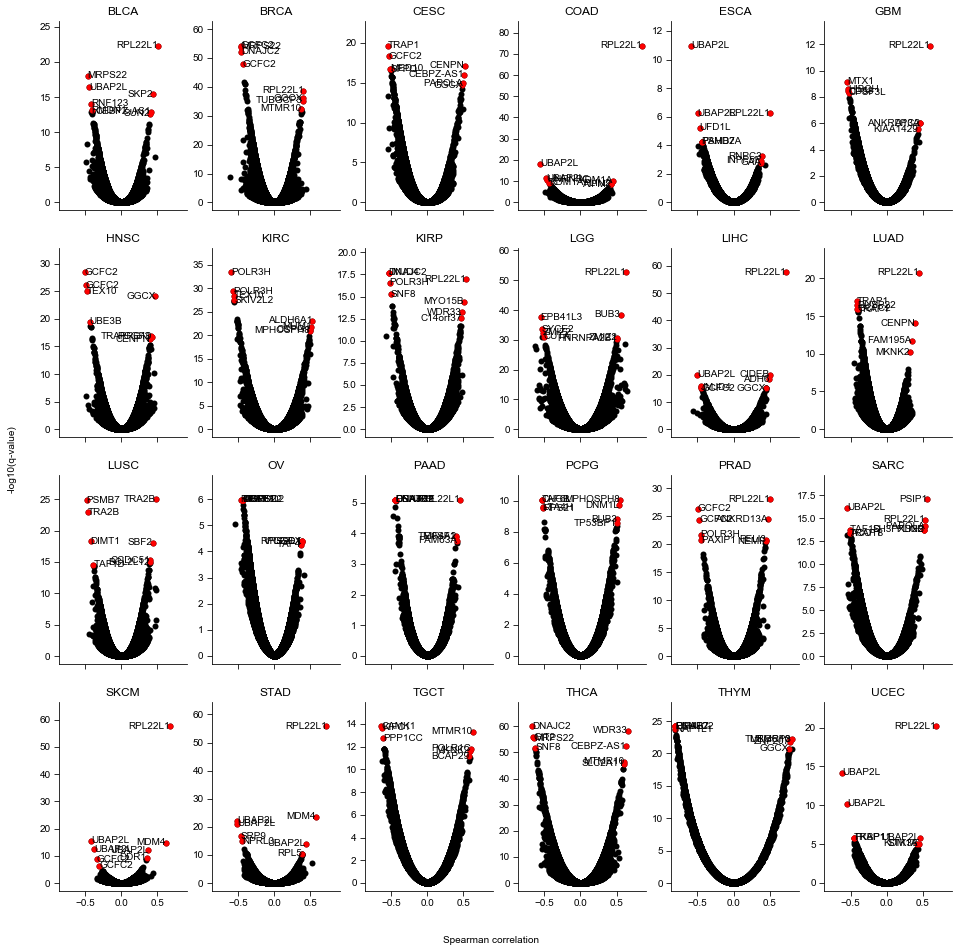

In [65]:
plot_subtype_corrs(rpl22l1_genex_splicing_subtyped,(4,6),(16,16))

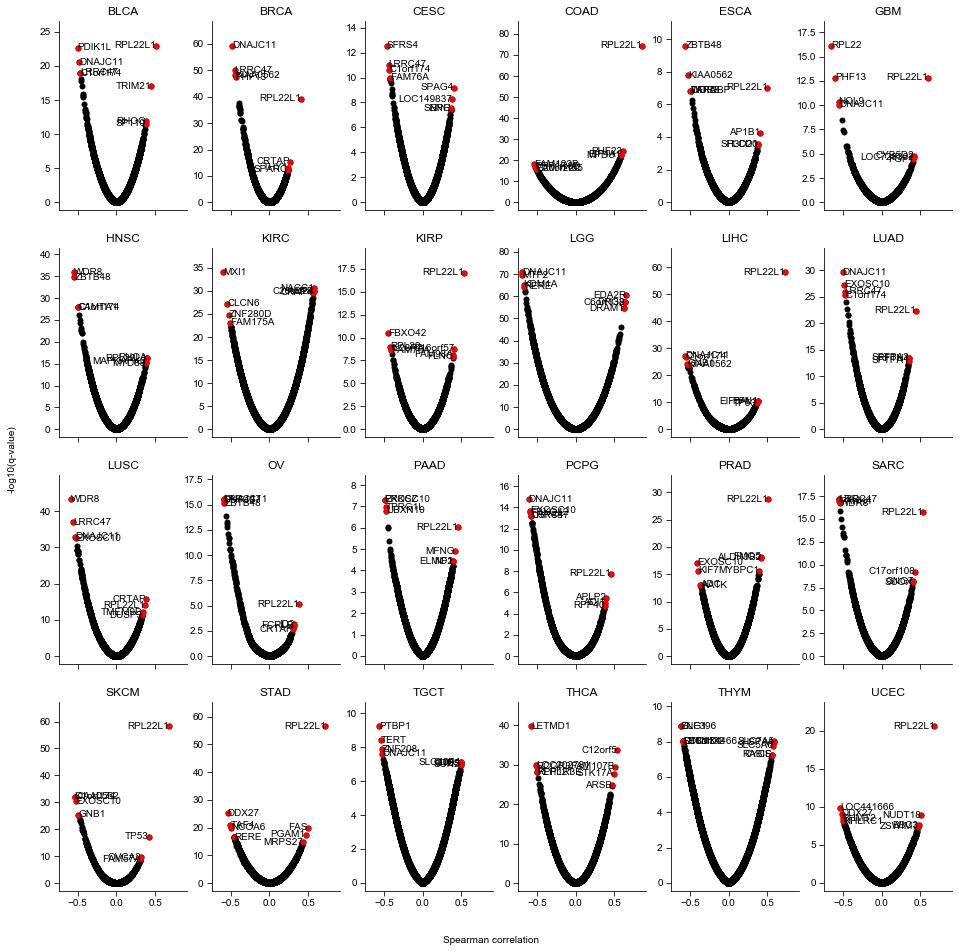

In [68]:
plot_subtype_corrs(rpl22l1_splicing_genex_subtyped,(4,6),(16,16))

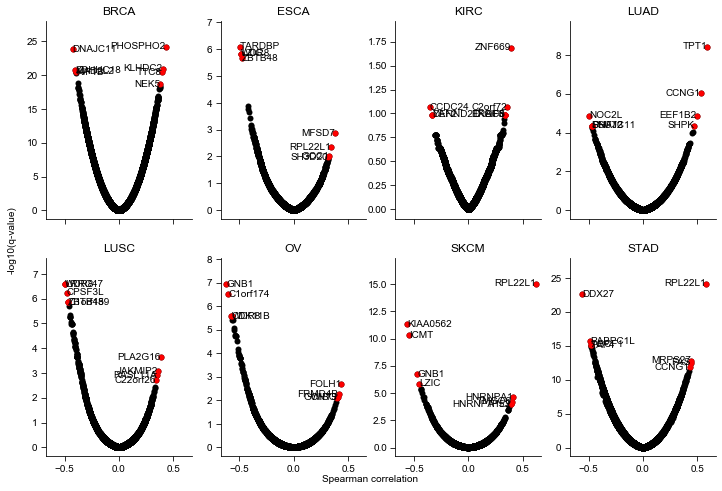

In [64]:
plot_subtype_corrs(mdm4_splicing_genex_subtyped,(2,4),(12,8))

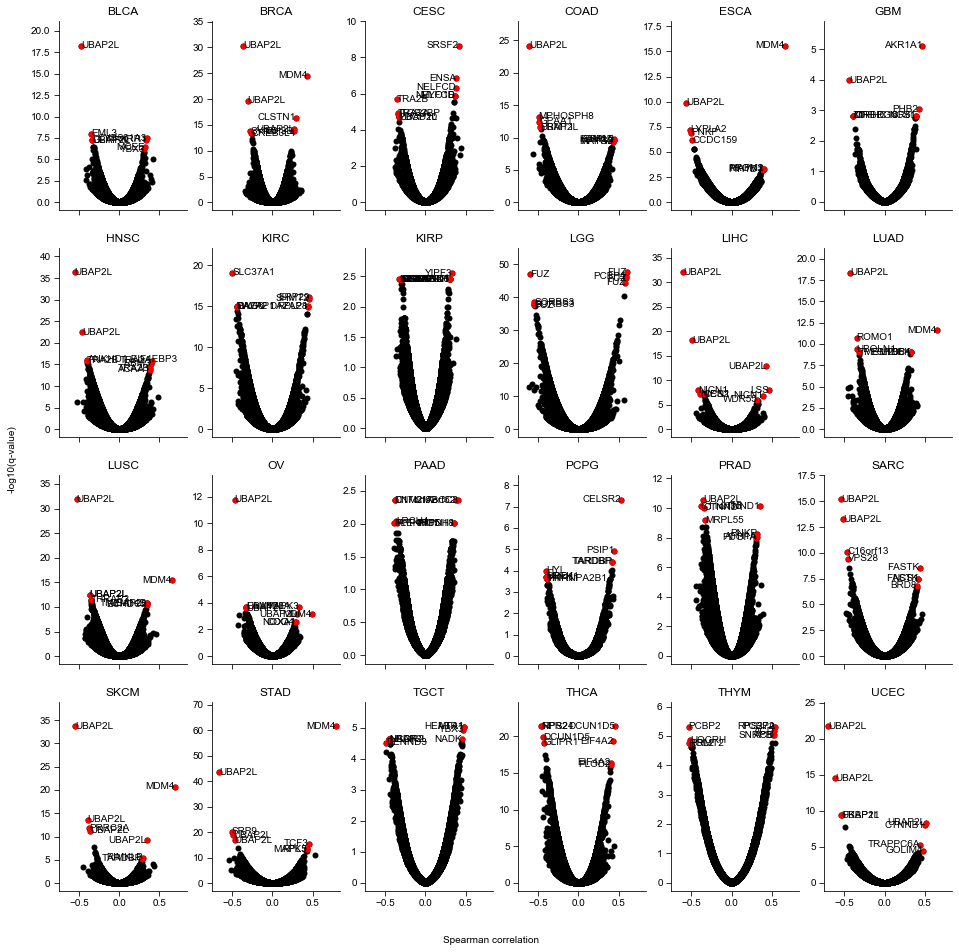

In [66]:
plot_subtype_corrs(rpl22l1_cosplicing_subtyped,(4,6),(16,16))

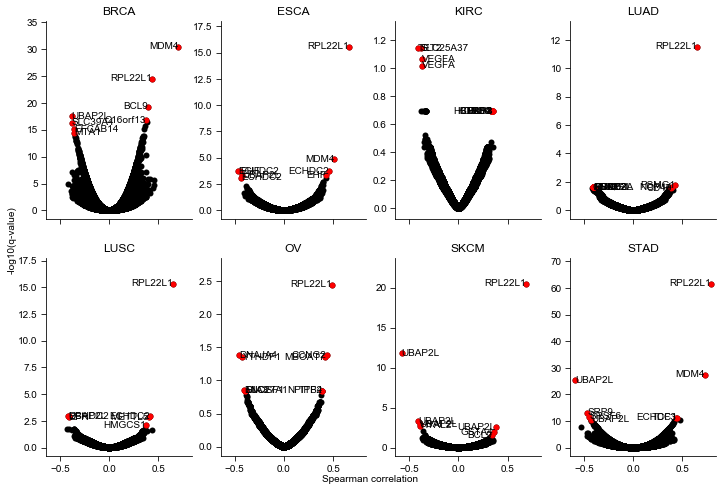

In [67]:
plot_subtype_corrs(mdm4_cosplicing_subtyped,(2,4),(12,8))

# RPL22 alterations by primary site

In [76]:
rpl22_subtype_info = rpl22_info.join(
    tcga_sample_info["abbreviated_disease"], how="inner")

subtype_proportions = rpl22_subtype_info.groupby(["abbreviated_disease"])[
    "RPL22_status"].value_counts()
subtype_proportions = subtype_proportions.unstack().fillna(0)

subtype_totals = subtype_proportions.sum(axis=1)

subtype_proportions = subtype_proportions.div(subtype_totals, axis=0)*100
subtype_proportions["total"] = subtype_totals.astype(int)

altered_classes = [
    "ΔCN=-1",
    "ΔCN=-2",
    "Truncating\nmutation",
]

subtype_proportions["altered_proportion"] = subtype_proportions[altered_classes].sum(
    axis=1)
subtype_proportions = subtype_proportions.sort_values(
    by="altered_proportion", ascending=False)

subtype_proportions["display_disease"] = subtype_proportions.index
subtype_proportions["display_disease"] = subtype_proportions["display_disease"] + \
    " (" + subtype_proportions["total"].astype(str) + ")"

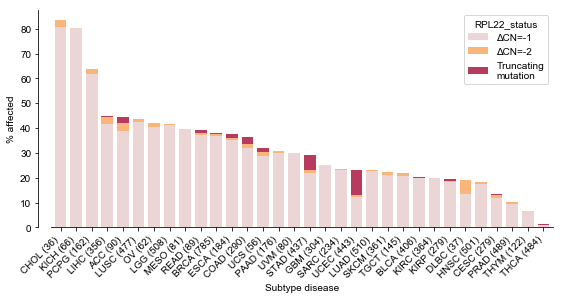

In [77]:
plt.figure(figsize=(9, 4))

ax = plt.subplot(111)

subtype_proportions.plot(x="display_disease",
                         y=altered_classes,
                         kind="bar",
                         stacked=True,
                         cmap=mpl.colors.ListedColormap(
                             ["#ebd5d5", "#fab57a", "#b83b5e"]),
                         ax=ax,
                         width=0.75
                         )

plt.xlabel("Subtype disease")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('axes', -0.025))

plt.xticks(rotation=45, ha="right")

plt.ylabel("% affected")

plt.savefig("../plots/rpl22_subtype_distribution.pdf",
            bbox_inches="tight", transparent=True)

# CCLE

In [2]:
ccle_genex = pd.read_hdf(
    "../../data/processed/ccle/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf", key="ccle_genex")
ccle_transcripts = pd.read_hdf("../../data/processed/ccle/CCLE_RNAseq_rsem_transcripts_tpm_20180929.hdf",
                        key="ccle_transcripts")
exonusage = pd.read_hdf(
    "../../data/processed/ccle/CCLE_RNAseq_ExonUsageRatio_20180929.hdf", key="exonusage")
ms_prot = pd.read_hdf("../../data/processed/ccle/ms_prot.h5",key="ms_prot")
rppa = pd.read_hdf("../../data/processed/ccle/CCLE_RPPA_20181003.hdf",key="rppa")

mdm4_exon_6 = exonusage[["MDM4_3p_chr1_204506558_204506625_ENSG00000198625.8",
                         "MDM4_5p_chr1_204506558_204506625_ENSG00000198625.8"
                        ]].mean(axis=1)

## RPPA correlations

In [8]:
mdm4_rppa = pd.concat([
    ccle_genex["MDM4_ENSG00000198625.8"].rename("MDM4_genex"),
    mdm4_exon_6.rename("MDM4_exon_6"),
    rppa["MDMX_MDM4(BetIHC-00108)_Caution"].rename("MDM4_protein")
],axis=1,sort=True)

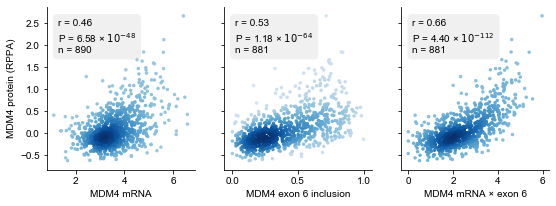

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

text_pos = (0.075, 0.925)

ax = axes[0]
huy.dense_regression(mdm4_rppa["MDM4_genex"],
                     mdm4_rppa["MDM4_protein"],
                     ax=ax,
                     s=12,
                     text_pos=text_pos
                     )
ax.set_ylabel("MDM4 protein (RPPA)")
ax.set_xlabel("MDM4 mRNA")

ax = axes[1]
huy.dense_regression(mdm4_rppa["MDM4_exon_6"],
                     mdm4_rppa["MDM4_protein"],
                     ax=ax,
                     s=12,
                     text_pos=text_pos
                     )
ax.set_xlabel("MDM4 exon 6 inclusion")

mult = np.log2(2**mdm4_rppa["MDM4_genex"]*mdm4_rppa["MDM4_exon_6"]+1)

ax = axes[2]
huy.dense_regression(mult,
                     mdm4_rppa["MDM4_protein"],
                     ax=ax,
                     s=12,
                     text_pos=text_pos
                     )

ax.set_xlabel("MDM4 mRNA × exon 6")

plt.savefig("../plots/MDM4_RPPA_correlations.pdf",
            bbox_inches="tight", transparent=True)

## Mass-spec correlations

In [11]:
mdm4_ms = pd.concat([
    ccle_genex["MDM4_ENSG00000198625.8"].rename("MDM4_genex"),
    mdm4_exon_6.rename("MDM4_exon_6"),
    ms_prot["MDM4_HUMAN_O15151"].rename("MDM4_protein")
], axis=1, sort=True)

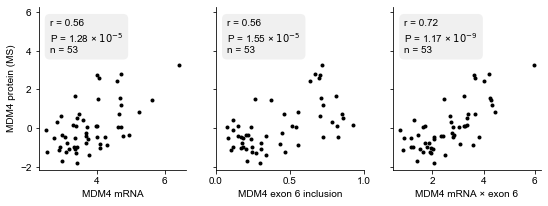

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

text_pos = (0.075, 0.925)

ax = axes[0]
huy.regression(mdm4_ms["MDM4_genex"],
               mdm4_ms["MDM4_protein"],
               ax=ax,
               s=16,
               text_pos=text_pos,
               alpha=1,
               c="black"
               )
ax.set_ylabel("MDM4 protein (MS)")
ax.set_xlabel("MDM4 mRNA")

ax = axes[1]
huy.regression(mdm4_ms["MDM4_exon_6"],
               mdm4_ms["MDM4_protein"],
               ax=ax,
               s=16,
               text_pos=text_pos,
               alpha=1,
               c="black"
               )
ax.set_xlabel("MDM4 exon 6 inclusion")
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])

mult = np.log2(2**mdm4_ms["MDM4_genex"]*mdm4_ms["MDM4_exon_6"]+1)

ax = axes[2]
huy.regression(mult,
               mdm4_ms["MDM4_protein"],
               ax=ax,
               s=16,
               text_pos=text_pos,
               alpha=1,
               c="black"
               )

ax.set_xlabel("MDM4 mRNA × exon 6")

ax.set_ylim(ax.set_ylim()[0], ax.set_ylim()[1]*1.75)

plt.savefig("../plots/MDM4_MS_correlations.pdf",
            bbox_inches="tight", transparent=True)